## import section

In [266]:
# Imports and constants
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import matplotlib.pyplot as plt

RANDOM_STATE = 42
# fixed random seed for reproducibility


## reading dataset

In [267]:
train_df = pd.read_csv("weekly-train-1.csv")
test_df  = pd.read_csv("weekly-test-1.csv")

train_df["DATE"] = pd.to_datetime(train_df["DATE"])
test_df["DATE"]  = pd.to_datetime(test_df["DATE"])


In [268]:
# Convert boolean flags to int
bool_cols = [c for c in train_df.columns if c.startswith("IS_")]
train_df[bool_cols] = train_df[bool_cols].astype(int)
test_df[bool_cols]  = test_df[bool_cols].astype(int)

train_df = train_df.sort_values(["PRODUCT_ID", "DATE"]).reset_index(drop=True)
test_df  = test_df.sort_values(["PRODUCT_ID", "DATE"]).reset_index(drop=True)


## validating the dataset

In [269]:
def check_missing_values(dataframe):
    return dataframe.isnull().sum().sum() == 0

In [270]:
def is_unique_product_date(dataframe):
    return not dataframe.duplicated(subset=["PRODUCT_ID", "DATE"]).any()


In [271]:
def is_product_id_unique(dataframe):
    return (
        dataframe.groupby("PRODUCT_DESC")["PRODUCT_ID"]
        .nunique()
        .eq(1)
        .all())

In [272]:
def check_total_sales_is_positive(dataframe):
    return (dataframe["TOTAL_SALES"] >= 0).all()

In [273]:
def check_price_is_positive(dataframe):
    return (dataframe["PRICE"] >= 0).all()

In [274]:
def count_total_sales_is_zero(dataframe):
    return int((dataframe["TOTAL_SALES"] == 0).sum())

In [275]:
def check_all_validations(dataframe):
    if check_missing_values(dataframe):
        print("No missing values found.")
    else:
        print("Missing values detected.")
    if is_unique_product_date(dataframe):
        print("Each product has a unique date.")
    else:
        print("Duplicate product-date combinations found.")
    if is_product_id_unique(dataframe):
        print("Each product description has a unique product ID.")
    else:
        print("Multiple product IDs found for the same product description.")
    if check_total_sales_is_positive(dataframe):
        print("All total sales values are non-negative.")
    else:
        print("Negative total sales values detected.")
    if check_price_is_positive(dataframe):
        print("All price values are non-negative.")
    else:
        print("Negative price values detected.")

In [276]:
check_all_validations(train_df)

No missing values found.
Each product has a unique date.
Each product description has a unique product ID.
All total sales values are non-negative.
All price values are non-negative.


In [277]:
count_total_sales_is_zero(train_df)
train_df = train_df[train_df["TOTAL_SALES"] > 0].reset_index(drop=True)

In [278]:
numberOfUniqueProducts = len(train_df["PRODUCT_DESC"].unique())
numberOfDataPoints = train_df.shape[0]
validationPortion = 0.2
numberOfValidationDataPoints = int(numberOfDataPoints * validationPortion)
numberOfValidationDataPointsPerProduct = numberOfValidationDataPoints // numberOfUniqueProducts
train_df["is_val"] = False

for pid, g in train_df.groupby("PRODUCT_ID"):
    val_idx = g.tail(numberOfValidationDataPointsPerProduct).index
    train_df.loc[val_idx, "is_val"] = True


## Feature engineering

In [279]:
normal_price_map = (
    train_df[train_df["IS_PROMO"] == 0]
    .groupby("PRODUCT_ID")["PRICE"]
    .max()
)

In [280]:
# Function to create features from raw data
def create_features(dataframe, normal_price):
    df = dataframe.copy()

    # ---- Price features ----
    # add lagged prices for temporal info
    for l in [4, 8]:
        df[f"price_lag_{l}"] = (df.groupby("PRODUCT_ID")["PRICE"].shift(l))
    df["normal_price"] = df["PRODUCT_ID"].map(normal_price)
    df["normal_price"] = df["normal_price"].replace(0, np.nan)
    df["rel_price"] = df["PRICE"] / df["normal_price"]
    df["promo_depth"] = 1 - df["rel_price"]

    df["price_change_1"] = df.groupby("PRODUCT_ID")["PRICE"].pct_change(1)
    df["price_change_4"] = df.groupby("PRODUCT_ID")["PRICE"].pct_change(4)
    # ---- Filtered Price Feature (Rolling Max, window=4) ----
    df['BASELINE_PRICE'] = df.groupby('PRODUCT_ID')['PRICE'].transform(lambda x: x.rolling(window=4, min_periods=1).max())


    # ---- Date features ----
    # week/month/year and cyclical week encoding
    df["WEEK"] = df["DATE"].dt.isocalendar().week.astype(int)
    df["MONTH"] = df["DATE"].dt.month
    df["YEAR"] = df["DATE"].dt.year
    df['sin_week'] = np.sin(2 * np.pi * df['WEEK'] / 52)
    df['cos_week'] = np.cos(2 * np.pi * df['WEEK'] / 52)


    # ---- Promotion features ----
    support_cols = ['IS_COUPON', 'IS_DISPLAY', 'IS_FEATURE']
    df['num_supports'] = df[support_cols].sum(axis=1)
    df['promo_intensity'] = df['IS_PROMO'] * df['num_supports']

    # # ---- Events Features ----
    # create interaction flags between holidays and promotions
    holidays = ['IS_INDEPENDENCE_DAY', 'IS_PRE_CHRISTMAS', 'IS_SUPER_BOWL_SUNDAY',
                'IS_PRE_THANKSGIVING', 'IS_EASTER_SUNDAY', 'IS_LABOR_DAY', 'IS_MEMORIAL_DAY',
                'IS_THANKSGIVING', 'IS_CHRISTMAS_DAY']
    for holiday in holidays:
        df[f'{holiday}_AND_PROMO'] = df[holiday] * df['IS_PROMO']


    return df


In [281]:
# Build features and drop the original holiday flags (they were combined above)
train_fe = create_features(train_df, normal_price_map)
holidays = ['IS_INDEPENDENCE_DAY', 'IS_PRE_CHRISTMAS', 'IS_SUPER_BOWL_SUNDAY',
                'IS_PRE_THANKSGIVING', 'IS_EASTER_SUNDAY', 'IS_LABOR_DAY', 'IS_MEMORIAL_DAY',
                'IS_THANKSGIVING', 'IS_CHRISTMAS_DAY']
train_fe = train_fe.drop(columns=holidays)
train_fe = train_fe.dropna().reset_index(drop=True)


In [282]:
target = "TOTAL_SALES"

drop_cols = [
    "TOTAL_SALES",
    "DATE",
    "PRODUCT_DESC",
    "is_val"
]

cat_features = ["PRODUCT_ID"]


features = [c for c in train_fe.columns if c not in drop_cols]

X_train = train_fe[~train_fe["is_val"]][features]
y_train = train_fe[~train_fe["is_val"]][target]

X_val = train_fe[train_fe["is_val"]][features]
y_val = train_fe[train_fe["is_val"]][target]

## Model implementation

In [283]:
# initial labels (will be filtered to available estimators)
model_labels = [
    'lr',
    'catboost',
    'rf',
    'xgboost',
    'lightgbm'
]

models = {
    'lr': {
        "name": "Linear Regression",
        "estimator": LinearRegression(),
        "params": {
            'fit_intercept': [True, False],
            'copy_X': [True, False],
        }
    },

    'catboost': {
        "name": "CatBoost Regressor",
        "estimator": CatBoostRegressor(random_state=RANDOM_STATE, verbose=0),
        "params": {
            "iterations": [1200,1600],
            "learning_rate": [0.05, 0.1],
            "depth": [6, 8],
            "loss_function": ["MAE"],
            "eval_metric": ["MAE"],
        }
    },

    'rf': {
        "name": "Random Forest Regressor",
        "estimator": RandomForestRegressor(random_state=RANDOM_STATE),
        "params": {
            "n_estimators": [1800],
            "max_depth": [None, 10],
            "min_samples_leaf": [1, 5]
        }
    },

    'xgboost': {
        "name": "XGBoost Regressor",
        "estimator": XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=0),
        "params": {
            "n_estimators": [1800],
            "learning_rate": [0.05, 0.1],
            "max_depth": [6, 8],
            "subsample": [0.8],
        }
    },

    'lightgbm': {
        "name": "LightGBM Regressor",
        "estimator": LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
        "params": {
            "n_estimators": [1800],
            "learning_rate": [0.05, 0.1],
            "max_depth": [6, 8],
            "num_leaves": [31, 63],
            "subsample": [0.8],
        }
    }
}


In [284]:
best_models = {}
cv_results = {}

X_combined = train_fe[features]
y_combined = train_fe[target]

split_index = train_fe["is_val"].map({False: -1, True: 0}).tolist()
ps = PredefinedSplit(test_fold=split_index)

for key in model_labels:
    model_info = models[key]
    name = model_info["name"]

    print(f"\nTraining and tuning {name}...")

    estimator = model_info["estimator"]

    grid = GridSearchCV(
        estimator=estimator,
        param_grid=model_info["params"],
        scoring='neg_mean_absolute_percentage_error',
        cv=ps,
        n_jobs=-1,
        return_train_score=False
    )

    # Fit on combined dataset
    grid.fit(X_combined, y_combined)

    best_models[key] = grid.best_estimator_
    cv_results[key] = -grid.best_score_

    print(f"Best parameters: {grid.best_params_}")
    print(f"Validation MAPE: {-grid.best_score_:.4f}")



Training and tuning Linear Regression...
Best parameters: {'copy_X': True, 'fit_intercept': False}
Validation MAPE: 1.4433

Training and tuning CatBoost Regressor...
Best parameters: {'depth': 6, 'eval_metric': 'MAE', 'iterations': 1200, 'learning_rate': 0.05, 'loss_function': 'MAE'}
Validation MAPE: 0.4044

Training and tuning Random Forest Regressor...
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 1800}
Validation MAPE: 0.2065

Training and tuning XGBoost Regressor...
Best parameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1800, 'subsample': 0.8}
Validation MAPE: 0.2252

Training and tuning LightGBM Regressor...
Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1800, 'num_leaves': 31, 'subsample': 0.8}
Validation MAPE: 0.2090


In [285]:
# Choose the best trained model from the cross-validated results
best_key = min(cv_results, key=cv_results.get)
best_model = best_models[best_key]
print(f"Using best trained model: {best_key} with validation MAPE {cv_results[best_key]:.4f}")


Using best trained model: rf with validation MAPE 0.2065


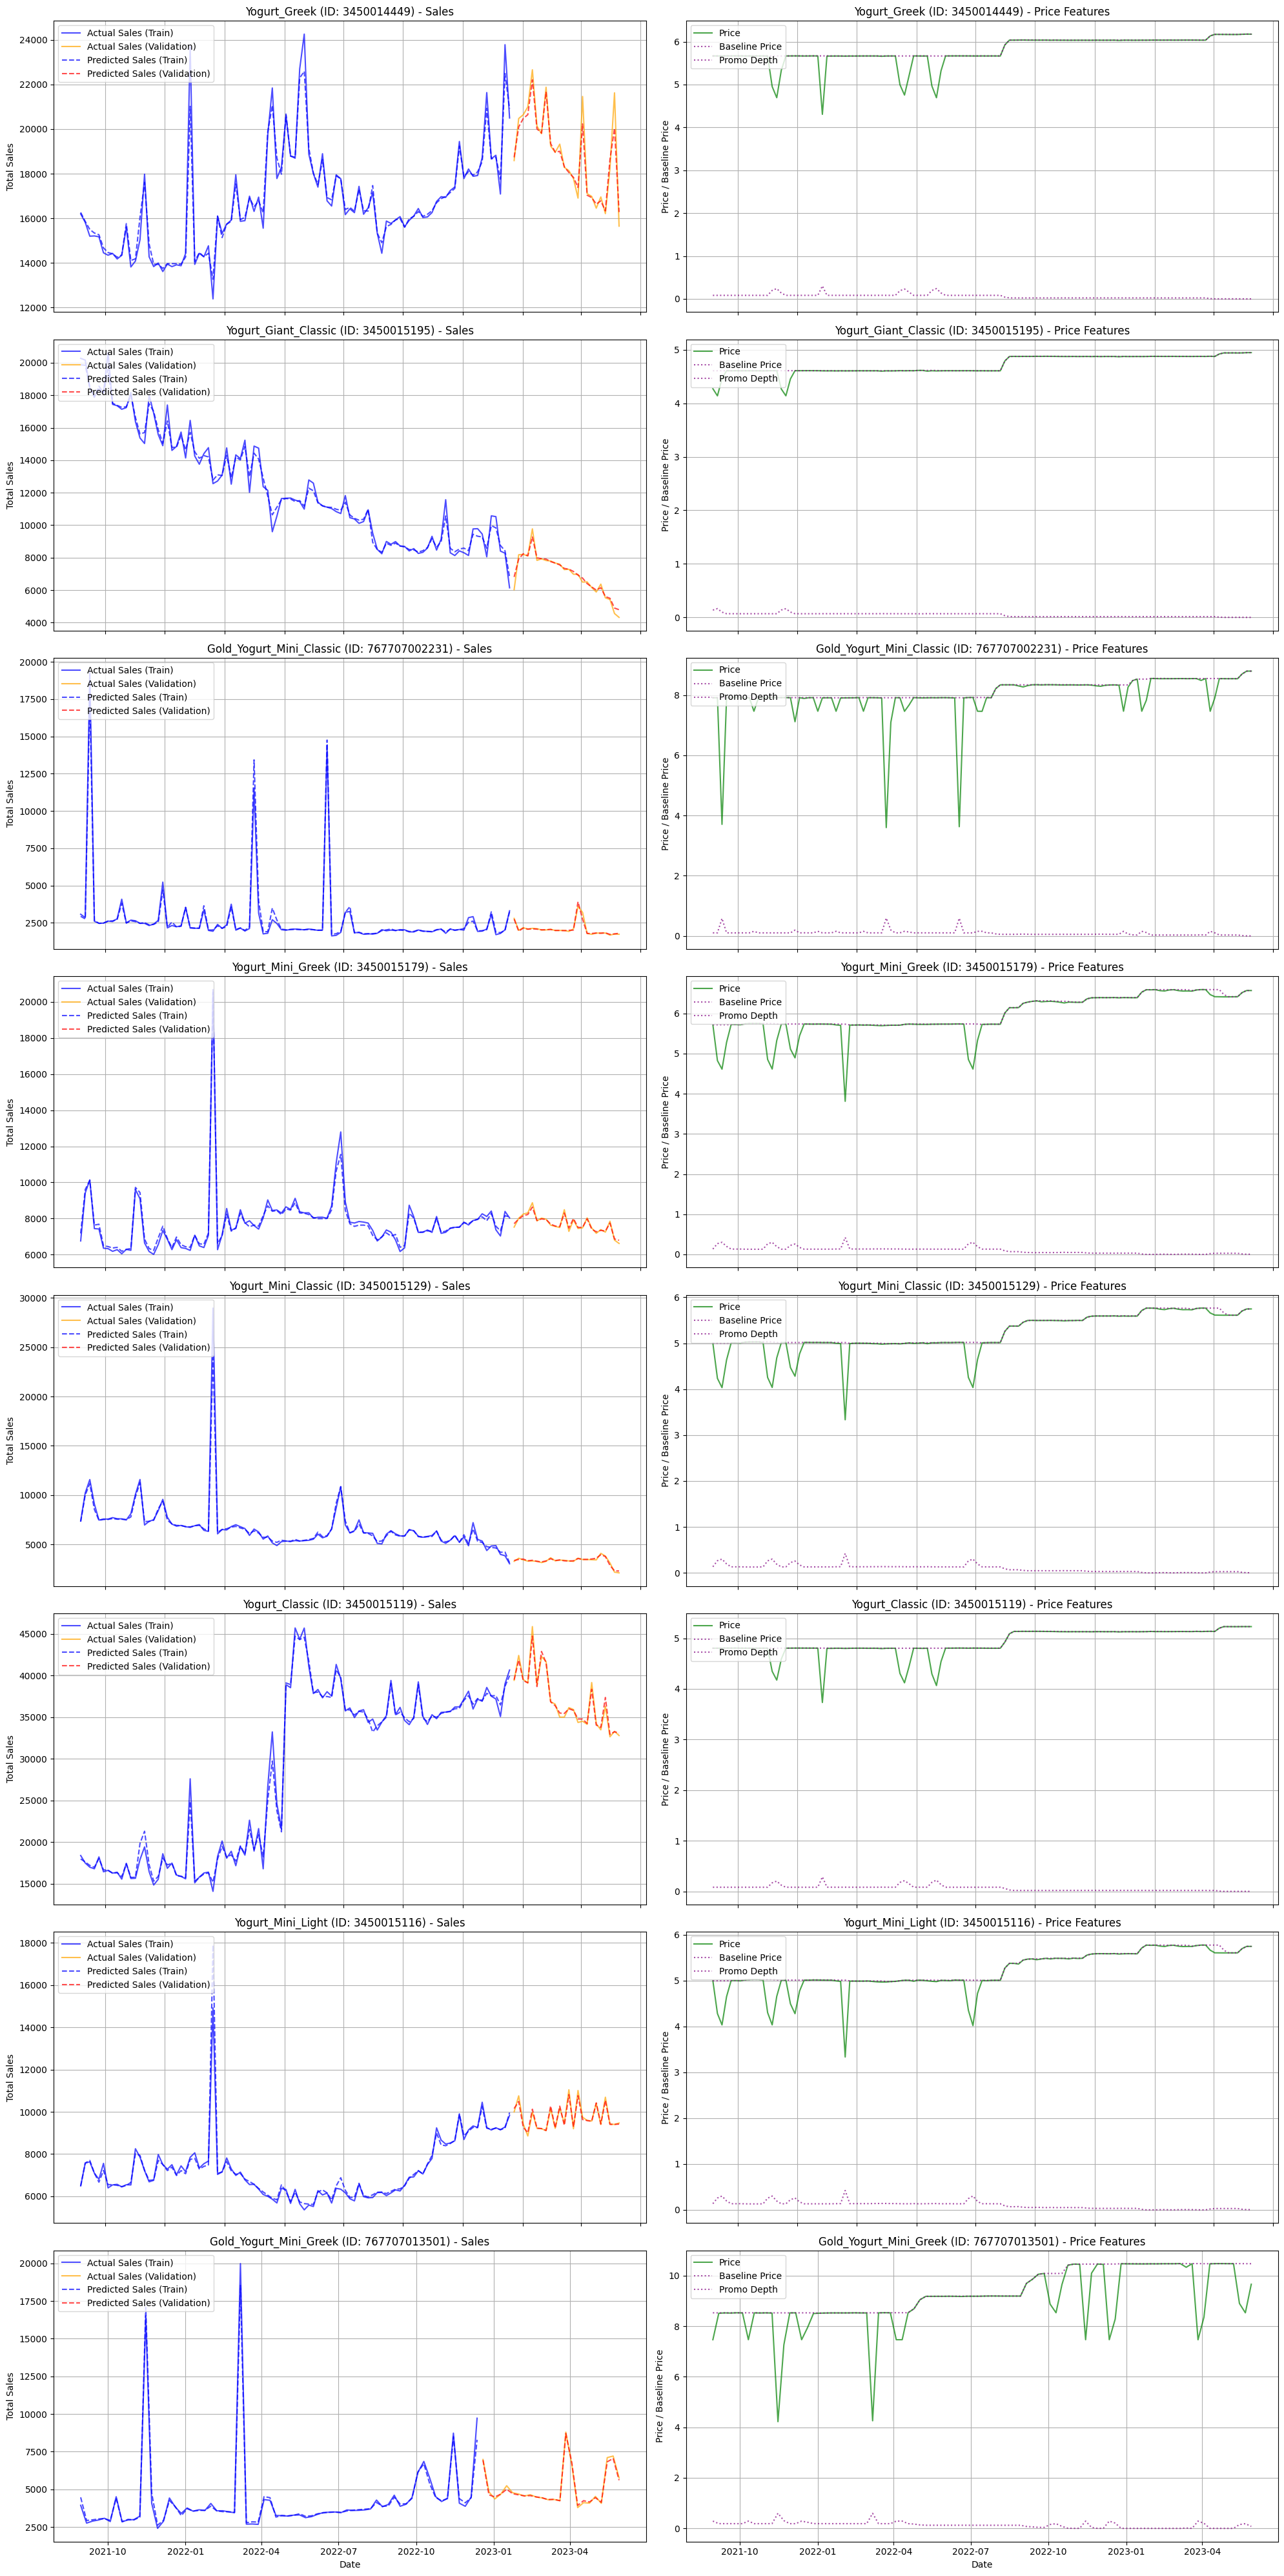

In [286]:
# Make predictions
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

# Prepare data for plotting
# Training set
train_plot_df = pd.DataFrame({
    'DATE': train_fe[~train_fe["is_val"]]['DATE'].reset_index(drop=True),
    'Actual_Sales': y_train.reset_index(drop=True),
    'Predicted_Sales': y_train_pred,
    'Set': 'Train',
    'PRODUCT_ID': train_fe[~train_fe["is_val"]]['PRODUCT_ID'].reset_index(drop=True),
    'PRODUCT_DESC': train_fe[~train_fe["is_val"]]['PRODUCT_DESC'].reset_index(drop=True),
    'PRICE': train_fe[~train_fe["is_val"]]['PRICE'].reset_index(drop=True),
    'BASELINE_PRICE': train_fe[~train_fe["is_val"]]['BASELINE_PRICE'].reset_index(drop=True),
    'promo_depth': train_fe[~train_fe["is_val"]]['promo_depth'].reset_index(drop=True)
})

# Validation set
val_plot_df = pd.DataFrame({
    'DATE': train_fe[train_fe["is_val"]]['DATE'].reset_index(drop=True),
    'Actual_Sales': y_val.reset_index(drop=True),
    'Predicted_Sales': y_val_pred,
    'Set': 'Validation',
    'PRODUCT_ID': train_fe[train_fe["is_val"]]['PRODUCT_ID'].reset_index(drop=True),
    'PRODUCT_DESC': train_fe[train_fe["is_val"]]['PRODUCT_DESC'].reset_index(drop=True),
    'PRICE': train_fe[train_fe["is_val"]]['PRICE'].reset_index(drop=True),
    'BASELINE_PRICE': train_fe[train_fe["is_val"]]['BASELINE_PRICE'].reset_index(drop=True),
    'promo_depth': train_fe[train_fe["is_val"]]['promo_depth'].reset_index(drop=True)
})

# Combine train and validation dataframes
combined_plot_df = pd.concat([train_plot_df, val_plot_df])
combined_plot_df = combined_plot_df.sort_values(by='DATE').reset_index(drop=True)

# Get unique products
unique_products = combined_plot_df['PRODUCT_ID'].unique()
num_products = len(unique_products)

# Determine grid size for subplots: 2 columns, one for sales, one for prices
rows = num_products
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), squeeze=False)

for i, product_id in enumerate(unique_products):
    product_data = combined_plot_df[combined_plot_df['PRODUCT_ID'] == product_id].sort_values(by='DATE')
    product_desc = product_data['PRODUCT_DESC'].iloc[0] if not product_data.empty else f"Product {product_id}"

    # --- Sales Plot ---
    ax_sales = axes[i, 0] # First column for sales
    ax_sales.plot(product_data[product_data['Set'] == 'Train']['DATE'],
                  product_data[product_data['Set'] == 'Train']['Actual_Sales'],
                  label='Actual Sales (Train)', color='blue', alpha=0.7)
    ax_sales.plot(product_data[product_data['Set'] == 'Validation']['DATE'],
                  product_data[product_data['Set'] == 'Validation']['Actual_Sales'],
                  label='Actual Sales (Validation)', color='orange', alpha=0.7)
    ax_sales.plot(product_data[product_data['Set'] == 'Train']['DATE'],
                  product_data[product_data['Set'] == 'Train']['Predicted_Sales'],
                  label='Predicted Sales (Train)', color='blue', linestyle='--', alpha=0.7)
    ax_sales.plot(product_data[product_data['Set'] == 'Validation']['DATE'],
                  product_data[product_data['Set'] == 'Validation']['Predicted_Sales'],
                  label='Predicted Sales (Validation)', color='red', linestyle='--', alpha=0.7)
    ax_sales.set_ylabel("Total Sales")
    ax_sales.set_title(f"{product_desc} (ID: {product_id}) - Sales")
    ax_sales.legend(loc='upper left')
    ax_sales.grid(True)
    if i == rows - 1: # Only set xlabel for the bottom row
        ax_sales.set_xlabel("Date")
    else:
        ax_sales.tick_params(axis='x', labelbottom=False)

    # --- Price Plot ---
    ax_price = axes[i, 1] # Second column for prices
    ax_price.plot(product_data['DATE'], product_data['PRICE'], label='Price', color='green', linestyle='-', alpha=0.7)
    ax_price.plot(product_data['DATE'], product_data['BASELINE_PRICE'], label='Baseline Price', color='purple', linestyle=':', alpha=0.7)
    ax_price.plot(product_data['DATE'], product_data['promo_depth'], label='Promo Depth', color='purple', linestyle=':', alpha=0.7)
    ax_price.set_ylabel("Price / Baseline Price")
    ax_price.set_title(f"{product_desc} (ID: {product_id}) - Price Features")
    ax_price.legend(loc='upper left')
    ax_price.grid(True)
    if i == rows - 1: # Only set xlabel for the bottom row
        ax_price.set_xlabel("Date")
    else:
        ax_price.tick_params(axis='x', labelbottom=False)

plt.tight_layout()
plt.show()

## Test set predictions
 Prepare and feature-engineer the test CSV
 Predict using the selected trained model
 Output predictions for later analysis or submission

In [287]:
# Prepare test set and make predictions
test_df  = pd.read_csv("weekly-test-1.csv")
test_df["DATE"]  = pd.to_datetime(test_df["DATE"])
bool_cols = [c for c in train_df.columns if c.startswith("IS_")]
test_df[bool_cols]  = test_df[bool_cols].astype(int)
test_df  = test_df.sort_values(["PRODUCT_ID", "DATE"]).reset_index(drop=True)

# Create test features and prepare test dataframe for prediction
test_fe = create_features(test_df, normal_price_map)
test_fe_2 = test_fe.dropna().reset_index(drop=True)

# Final predictions from the best model
y_prediction = best_model.predict(test_fe_2[features])


In [288]:
y_prediction.shape

(352,)

In [290]:
df = pd.read_csv("weekly-test-1.csv")

# number of missing rows at the top
n_missing = len(df) - len(y_prediction)

# create full column with NaNs first
target_column = [np.nan] * n_missing + list(y_prediction)

# assign to dataframe
df["Target"] = target_column
df.to_csv("Group_1.csv", index=False)
